In this notebook, I'll provide an overview on Automatic Speech Architecture, its standard pipelines, and how to train a model for it!

### What is Automatic Speech Recognition?
Automatic Speech Recognition (ASR) is the translation of spoken speech to text by a computer.

It has many uses:
+ closed captioning
+ mobile phone voice assistants
+ interface for handicapped individuals
+ preserve endangered languages

However, ASR is very difficult to solve due to:
+ Environment (Is there noise? Other speakers?)
+ Style of speech (Is it casual, formal, poetic, etc?)
+ Style of speaker (Talks fast? Accents? Gender bias?)

https://www.youtube.com/watch?v=q67z7PTGRi8

Modern ASR models work quite well in ideal, noiseless conditions. However, in noisy conditions they are far from perfect. Below, we can see the typical accuracy for state-of-the-art ASR models in 2020!

(Note: To calculate the accuracy of ASR models, we use a 'Word Error Rate.' This determines which percentage of spoken words were incorrectly translated to text by the ASR model. )

![word error rate](https://drive.google.com/uc?export=view&id=1iUz9koIqQErBVB0a4db0gSZVdfsfwh9L)



Architecture:

![timeline](https://drive.google.com/uc?export=view&id=1n2ID2ML5x9TFSBJhfdvj5AGI4u-9Mp4m)


From the 1980s to the 2010s, ASR was predominately performed by Hidden Markov Model (HMM) architecture. HMMs are probabilistic models for linear sequence classification problems. Given text's linear nature, HMMs seem like a natural fit for ASR.
However, using HMMs for ASR come with 3 downsides:
+ HMMs are built on the Markov Assumption, which assumes that the probability of the next state only depends on the current state, and not any states prior. This doesn't make sense for language processing, which is highly contextual (see Coarticulation)
+ HMMs' state transitions probabilities are 'baked in' and thus inflexible to changes in language
+ Classic HMM ASR pipelines require hand-tuned probability distributions for accoustic models and language models from linguistic experts
+ HMM-based ASR architecture is very complex, requiring 3 models as input. The figure below demonstrates an HMM-centric ASR architecture

![an HMM-based architecture](https://drive.google.com/uc?export=view&id=1loF8wbD-6DRO45Ly7lKnVVIcCn83H-B9)

Nowadays Recurrent Neural Networks (RNNs) or RNN-HMM hybrids are favored for ASR because they solve these problems. However, RNN's come at the cost of requiring a vast amount of training data.

![an RNN-only architecture](https://drive.google.com/uc?export=view&id=1_9McwMlHIqlPuJGYOkPwB-8h-t13P4pI)
(an RNN-only model that has only 4 steps)

https://stats.stackexchange.com/questions/282987/hidden-markov-model-vs-recurrent-neural-network
Jurafsky textbook

For the our ASR model, we'll be using an 'Listen, Attend, and Spell' (LAS) RNN. The LAS was proposed by in 2016 for ASR architecture in order to simplify Hybrid architecture (such as DNN-HMMs or CTC-HMMs) and avoid the aforementioned independence assumptions. Since then it has been the forefront of ASR architecture.

https://storage.googleapis.com/pub-tools-public-publication-data/pdf/44926.pdf

The objective of LAS is to transform an arbitrary-length input sequence to an arbitrary-length output sequence. LAS is an encoder-decoder model- a class of RNN's that is well-suited for problems where the length of the inputs greatly differs from the length of the outputs (like ASR).

Encoder-Decoder models are composed of 3 parts:
+ an Encoder
+ a Context Vector
+ a Decoder

The Encoder compresses and summarizes input data into a Context Vector, which is later transformed by the Decoder. The Context Vector must be defined with a fixed-length (usually 256, 512, or 1024).

Accoustic Information as Input for RNN:
A classic HMM-based ASR model would require us to input 3 probabilistic models (accoustic, pronunciation, and language), whereas an RNN only requires 1 (accoustic). The accoustic model captures important characteristics about how we perceive speech (see MFCC). We'll extract this data from the LibriSpeech ASR dataset.

https://www.openslr.org/12

We need to first extract features from the audio files- we'll be putting these features in a vector and feeding them into the RNN.
In order to extract the features from a given file, we need to perform the following steps:
```
1) Convert the FLAC file into a Waveform (giving us frequency data over the time domain)
2) Split the Waveform into Windows using a Windowing Function (like Hamming)
3) For each Window:
    a) Compute its Fourier Transform
    b) Compute its Mel Spectrogram
    c) Compute the log of each value in the Mel Spectrogram
    d) Append the result of 3c to the Features Vector
4) Return Features Vector
```



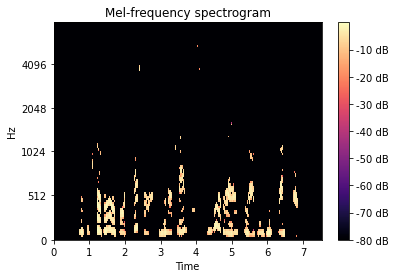

In [10]:
import librosa, librosa.display
import matplotlib.pyplot as plt

test_path = './data/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac'

def flac_to_log_mel(filepath, sample_rate=16000):  # LibriSpeech uses a 16kHz sample rate
    # sample_rate = 16000  # because
    window_length_ms = 25  # for ASR, the window length is typically 25ms, ranging from 15-40ms
    window_step_ms = 10
    audio_data, sample_rate = librosa.load(filepath, sr=sample_rate)
    audio_duration_seconds = len(audio_data)/sample_rate
    window_count = int(audio_duration_seconds*1000/window_length_ms)
    window_length =int(sample_rate/1000 * window_length_ms)  # for more info on Windowing see https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/
    N = 2048 # for FFT, the FT window length should be a power of 2
    mel_spec = librosa.feature.melspectrogram(audio_data, sample_rate, n_fft=N, win_length=window_length, hop_length=window_length, window="hann")
    log_mel_spec = np.log(mel_spec)
    return log_mel_spec

def show_spec(signal, sample_rate):
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(signal, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',

                             y_axis='mel', sr=sample_rate,

                             fmax=8000, ax=ax)

    fig.colorbar(img, ax=ax, format='%+2.0f dB')

    ax.set(title='Mel-frequency spectrogram')


sample_rate = 16000
log_mel_spec = flac_to_log_mel(test_path)
show_spec(log_mel_spec, sample_rate)

In [1]:
import python_speech_features as psf
import numpy as np

def signal_to_log_mel(signal,sample_rate,win_len,win_step,n_filt,low_freq,hi_freq,preemph,win_func):
    n_fft = psf.calculate_nfft(sample_rate, win_len)
    feat,energy = psf.fbank(signal,sample_rate,win_len,win_step,n_filt, n_fft, low_freq,hi_freq,preemph,win_func)
    feat = np.log(feat)
    print(feat)
    # feat = psf.dct(feat, type=2, axis=1, norm='ortho')[:,:numcep]
    # feat = psf.lifter(feat,ceplifter)
    # if appendEnergy: feat[:,0] = numpy.log(energy) # replace first cepstral coefficient with log of frame energy

def extract_features():
    window_length_sec = 25/1000  # for ASR, the window length is typically 25ms, ranging from 15-40ms
    window_step_sec = 10/1000
    sample_rate = 16000

    test_path = './data/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac'
    audio_data, sample_rate = librosa.load(test_path, sr=sample_rate)
    signal_to_log_mel(audio_data, sample_rate, window_length_sec, window_step_sec, n_filt=26,low_freq=0, hi_freq=None, preemph=0.97,win_func=np.hamming)

    # audio_duration_seconds = len(audio_data)/sample_rate
    # window_count = int(audio_duration_seconds*1000/window_length_ms)


In [83]:
# import glob, os
# def windows(data, window_size):
#     start = 0
#     while start < len(data):
#         yield int(start), int(start + window_size)
#         start += (window_size / 2)
#
# def extract_features(parent_dir, sub_dirs, file_ext="*.flac",bands=128,frames=128):
#     window_size = 400
#     log_specgrams = []
#     labels = []
#     ITJ = 0
#     for l,sub_dir in enumerate(sub_dirs):
#         PTJ = 1
#         for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
#             sound_clip, s = librosa.load(fn)
#             label = ITJ
#             for (start, end) in windows(sound_clip, window_size):
#                 if(len(sound_clip[start:end]) == window_size):
#                     signal = sound_clip[start:end]
#                     melspec = librosa.feature.melspectrogram(signal)
#                     logspec = librosa.amplitude_to_db(melspec)
#                     logspec = logspec.T.flatten()[:,np.newaxis].T
#                     log_specgrams.append(logspec)
#                     labels.append(label)
#             print(PTJ*ITJ*270, ITJ)
#             PTJ = PTJ+1
#         ITJ = ITJ+1
#     log_specgrams = np.array(log_specgrams)
#     print(log_specgrams.shape)
#     log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames)
#     features = log_specgrams
#     return np.array(features)
#
# extract_features('./data/LibriSpeech/dev-clean/1272/', ["128104",  "135031",  "141231"])


./data/LibriSpeech/dev-clean/1272/128104/*.flac
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


/home/a/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=400
  warnings.warn(


KeyboardInterrupt: 

Next we must obtain the frequency data across the time domain using a Fourier Transform. This is called a Spectrogram. However, human hearing is logarithmic; we are less sensitive to changes in high amplitude than we are to changes in low amplitude. To solve this we can map the Spectrogram to the Mel Scale, and then take the log of the result.

code:
- librosa.features.melspectrogram func
- librosa.logamplitude
- flatten
-

https://www.kdnuggets.com/2017/12/audio-classifier-deep-neural-networks.html

Next: build encoder-decoder architecture, based on https://github.com/tensorflow/nmt

Next: plug into RNN, run it on Google Colab. Save it

Next: let user input voice data, and run it through the model

More soucres
https://towardsdatascience.com/recognizing-speech-commands-using-recurrent-neural-networks-with-attention-c2b2ba17c837
https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html
https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
https://arxiv.org/pdf/1409.0473.pdf


Further Optimizations:

The Context Vector being fixed-length turns out to be a performance bottleneck; given a long input sentences, the the Encoder may not be able to store all of its output in the Context Vector in one timestep.

To solve the bottleneck, we could use the 'attention' mechanism which involves the Decoder selecting from all hidden states provided by the Encoder. For the sake of simplicity we won't be doing this optimization.
